# Import Libraries

In [29]:
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from arch.unitroot import PhillipsPerron
from scipy.stats import kruskal
import matplotlib.pyplot as plt
import pymannkendall as mk
import pandas as pd
from statsmodels.stats.diagnostic import het_arch
import numpy as np
from pykalman import KalmanFilter
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA


# p-value significance level
SIGNIFICANT_LEVEL = 0.05

# Data Loading

In [3]:
africa_df = pd.read_csv("./data/inflation/inflation_in_africa.csv", index_col=0)

In [4]:
africa_df.head()

,Real per Capita GDP Growth Rate (annual %),Real GDP growth (annual %),"Gross domestic product, (constant prices US$)","Gross domestic product, current prices (current US$)",Final consumption expenditure (current US$),General government final consumption expenditure (current US$),Household final consumption expenditure (current US$),Gross capital formation (current US$),"Gross capital formation, Private sector (current US$)","Gross capital formation, Public sector (current US$)",...,Imports of goods and services (% of GDP),"Central government, Fiscal Balance (Current US $)","Central government, total revenue and grants (Current US $)","Central government, total expenditure and net lending (Current US $)","Central government, Fiscal Balance (% of GDP)","Central government, total revenue and grants (% of GDP)","Central government, total expenditure and net lending (% of GDP)","Current account balance (Net, BoP, cur. US$)",Current account balance (As % of GDP),"Inflation, consumer prices (annual %)"
Year,,,,,,,,,,,,,,,,,,,,,
1980,0.971532,3.481958,13600.737325,10415.857407,5500.209700,1159.187997,4341.023179,1846.959092,1620.237774,1056.797145,...,36.167058,-281.629445,2004.025804,2266.199297,-5.651655,21.493650,26.743294,50.018376,-7.163063,13.037703
1981,-0.823321,2.054507,13744.409177,9891.282407,5863.216552,1239.321330,4623.896142,1973.862981,1662.408118,987.463475,...,37.646317,-490.911667,1975.049508,2446.505408,-6.331100,21.026243,26.955887,-329.303846,-7.639730,18.850817
1982,-0.179432,2.695989,14005.087510,9709.049444,5777.038774,1224.212441,4552.826883,1752.806685,1528.729229,893.654771,...,37.131317,-634.604260,1927.186545,2542.335408,-7.022581,22.110131,28.731072,-324.617735,-8.777878,15.254397
1983,-2.354617,0.458581,14052.476584,9884.352963,5491.232478,1205.945960,4285.286327,1646.330389,1413.759970,883.438104,...,34.617984,-542.346297,1849.040184,2389.676890,-5.822952,21.503899,27.217183,-160.231068,-5.734730,17.481248
1984,-0.871840,1.970618,14500.541769,9642.634259,5335.803034,1149.978923,4185.822994,1572.464463,1408.189229,818.120512,...,34.655762,-500.135371,1824.868147,2323.293001,-5.108322,21.344269,26.342183,-113.255513,-5.128804,17.460508


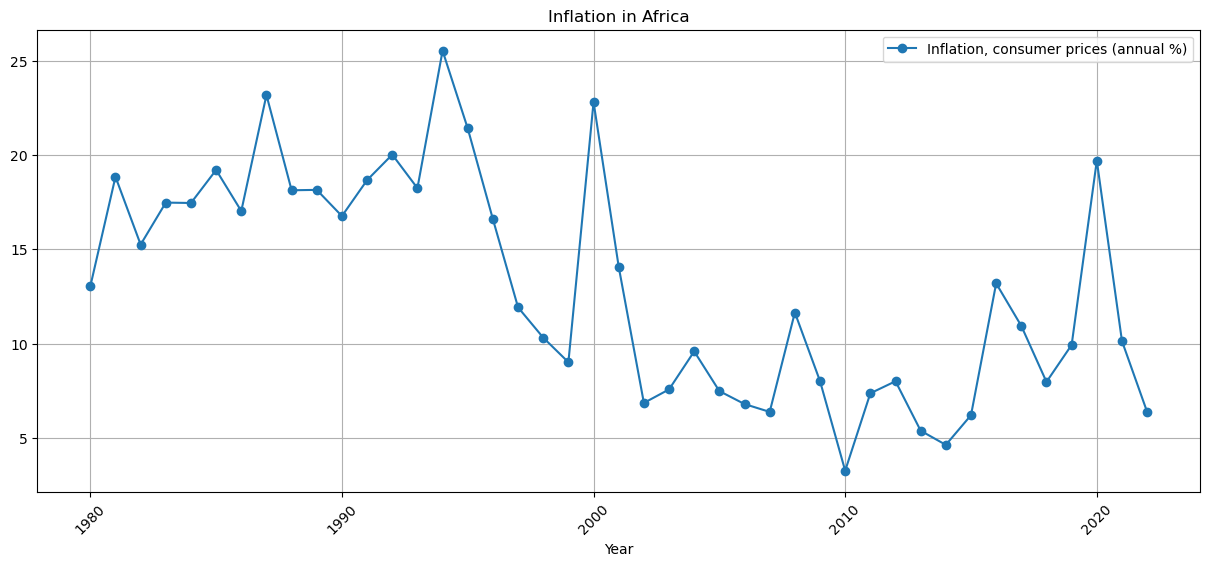

In [5]:
africa_df.plot(
    y="Inflation, consumer prices (annual %)",
    kind="line",
    marker="o",
    figsize=(15, 6),
    title="Inflation in Africa",
)

plt.xticks(rotation=45)
plt.grid()
plt.show()

# EDA

## Decomposition

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
decomposed = seasonal_decompose(
    africa_df["Inflation, consumer prices (annual %)"],
    model="additive",
    period=10,  # 10 years
)

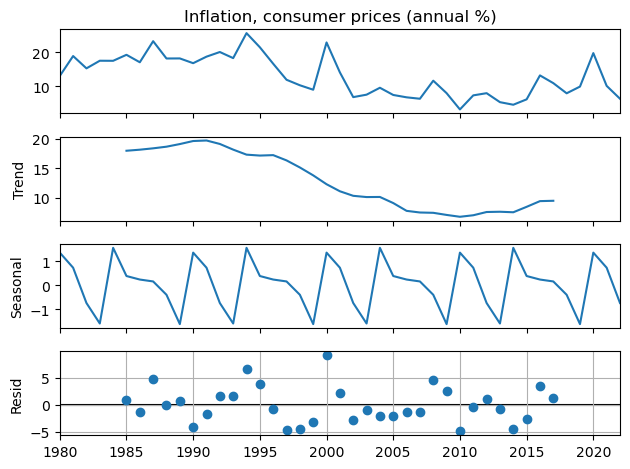

In [7]:
# Plot the decomposed time series
decomposed.plot()

plt.grid()

## Trend Test

In [8]:
mk.original_test(africa_df["Inflation, consumer prices (annual %)"])

Mann_Kendall_Test(trend='decreasing', h=True, p=5.3530495000231326e-05, z=-4.039652317181243, Tau=-0.42857142857142855, s=-387.0, var_s=9130.333333333334, slope=-0.3015878032376542, intercept=18.254080086664946)

## Seasonality Test

The null hypothesis for the Kruskal-Wallis test is that the medians of the groups are equal, which indicate the data has no seasonality.

In [9]:
h_stat, p_value = kruskal(*[africa_df[col] for col in africa_df.columns])

print(f"p-value: {p_value}")

if p_value < SIGNIFICANT_LEVEL:
    print(
        "Reject null hypothesis, There's a significant difference between the groups median"
    )
else:
    print("Fail to reject null hypothesis, The groups are similar")

p-value: 1.1592717695968135e-226
Reject null hypothesis, There's a significant difference between the groups median


## Stationarity Test

### Augmented Dickey-Fuller Test

The Augmented Dickey-Fuller (ADF) test is a statistical test used to check for the presence of a unit root in a time series. The null hypothesis for the ADF test is that a unit root is present in the time series, which means the series is non-stationary

In [10]:
for column in africa_df.columns:
    print(f"Dickey-Fuller test for {column}")
    p_value = adfuller(africa_df[column])[1]

    if p_value < SIGNIFICANT_LEVEL:
        print("Reject null hypothesis, time series is stationary")
    else:
        print("Fail to reject null hypothesis, time series is not stationary")

    print("-" * 70)

Dickey-Fuller test for Real per Capita GDP Growth Rate (annual %)
Reject null hypothesis, time series is stationary
----------------------------------------------------------------------
Dickey-Fuller test for Real GDP growth (annual %)
Reject null hypothesis, time series is stationary
----------------------------------------------------------------------
Dickey-Fuller test for Gross domestic product, (constant prices US$)
Fail to reject null hypothesis, time series is not stationary
----------------------------------------------------------------------
Dickey-Fuller test for Gross domestic product, current prices (current US$)
Fail to reject null hypothesis, time series is not stationary
----------------------------------------------------------------------
Dickey-Fuller test for Final consumption expenditure  (current US$)
Fail to reject null hypothesis, time series is not stationary
----------------------------------------------------------------------
Dickey-Fuller test for General

### Phillips-Perron test

In [11]:
for column in africa_df.columns:
    print(f"Phillips-Perron test for {column}")
    pp = PhillipsPerron(africa_df[column])

    print(pp.summary().as_text())
    print("+" * 70)

Phillips-Perron test for Real per Capita GDP Growth Rate (annual %)
     Phillips-Perron Test (Z-tau)    
Test Statistic                 -4.851
P-value                         0.000
Lags                               10
-------------------------------------

Trend: Constant
Critical Values: -3.60 (1%), -2.93 (5%), -2.60 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Phillips-Perron test for Real GDP growth (annual %)
     Phillips-Perron Test (Z-tau)    
Test Statistic                 -4.785
P-value                         0.000
Lags                               10
-------------------------------------

Trend: Constant
Critical Values: -3.60 (1%), -2.93 (5%), -2.60 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


### Granger causality test

The test is used to measure the ability to predict the future values of a time series using prior values of another time series.

The null hypothesis for the Granger causality test is that there is no effect of X on Y. If the p-value of the test is less than the significance level, then the null hypothesis is rejected, indicating that X does have a Granger-causal effect on Y.

In [12]:
for column in africa_df.columns:
    print(f"Granger causality test for {column}")
    print(
        grangercausalitytests(
            africa_df[["Inflation, consumer prices (annual %)", column]], maxlag=10
        )
    )
    print("-" * 70)

Granger causality test for Real per Capita GDP Growth Rate (annual %)

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7778  , p=0.3832  , df_denom=39, df_num=1
ssr based chi2 test:   chi2=0.8376  , p=0.3601  , df=1
likelihood ratio test: chi2=0.8294  , p=0.3625  , df=1
parameter F test:         F=0.7778  , p=0.3832  , df_denom=39, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7753  , p=0.4681  , df_denom=36, df_num=2
ssr based chi2 test:   chi2=1.7659  , p=0.4136  , df=2
likelihood ratio test: chi2=1.7290  , p=0.4213  , df=2
parameter F test:         F=0.7753  , p=0.4681  , df_denom=36, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.3250  , p=0.2828  , df_denom=33, df_num=3
ssr based chi2 test:   chi2=4.8183  , p=0.1856  , df=3
likelihood ratio test: chi2=4.5495  , p=0.2079  , df=3
parameter F test:         F=1.3250  , p=0.2828  , df_denom=33, df_num=3

Granger Causality
number of l

In [13]:
# differentiate the time series to remove the trend
detrend_df = africa_df.diff().dropna()

In [14]:
# Apply granger causality test on the differenced time series
for column in detrend_df.columns:
    print(f"Granger causality test for {column}")
    print(
        grangercausalitytests(
            detrend_df[["Inflation, consumer prices (annual %)", column]], maxlag=10
        )
    )

Granger causality test for Real per Capita GDP Growth Rate (annual %)

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6385  , p=0.4292  , df_denom=38, df_num=1
ssr based chi2 test:   chi2=0.6889  , p=0.4065  , df=1
likelihood ratio test: chi2=0.6832  , p=0.4085  , df=1
parameter F test:         F=0.6385  , p=0.4292  , df_denom=38, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.9001  , p=0.1647  , df_denom=35, df_num=2
ssr based chi2 test:   chi2=4.3431  , p=0.1140  , df=2
likelihood ratio test: chi2=4.1231  , p=0.1273  , df=2
parameter F test:         F=1.9001  , p=0.1647  , df_denom=35, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1181  , p=0.3563  , df_denom=32, df_num=3
ssr based chi2 test:   chi2=4.0879  , p=0.2521  , df=3
likelihood ratio test: chi2=3.8876  , p=0.2739  , df=3
parameter F test:         F=1.1181  , p=0.3563  , df_denom=32, df_num=3

Granger Causality
number of l

parameter F test:         F=0.4516  , p=0.8363  , df_denom=23, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.6306  , p=0.7253  , df_denom=20, df_num=7
ssr based chi2 test:   chi2=7.7246  , p=0.3575  , df=7
likelihood ratio test: chi2=6.9799  , p=0.4310  , df=7
parameter F test:         F=0.6306  , p=0.7253  , df_denom=20, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.6427  , p=0.7323  , df_denom=17, df_num=8
ssr based chi2 test:   chi2=10.2837 , p=0.2457  , df=8
likelihood ratio test: chi2=8.9847  , p=0.3436  , df=8
parameter F test:         F=0.6427  , p=0.7323  , df_denom=17, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.6510  , p=0.7381  , df_denom=14, df_num=9
ssr based chi2 test:   chi2=13.8114 , p=0.1292  , df=9
likelihood ratio test: chi2=11.5374 , p=0.2407  , df=9
parameter F test:         F=0.6510  , p=0.7381  , df_denom=14, df_num=9

Granger Causality
number of

# Kalman Filter

In [15]:
filtered_df = pd.DataFrame(columns=detrend_df.columns, index=detrend_df.index)

In [16]:
for column in detrend_df.columns:
    kf = KalmanFilter()
    filtered_state_means, _ = kf.filter(detrend_df[column].values)
    filtered_df[column] = filtered_state_means.flatten()

In [17]:
filtered_df.head()

,Real per Capita GDP Growth Rate (annual %),Real GDP growth (annual %),"Gross domestic product, (constant prices US$)","Gross domestic product, current prices (current US$)",Final consumption expenditure (current US$),General government final consumption expenditure (current US$),Household final consumption expenditure (current US$),Gross capital formation (current US$),"Gross capital formation, Private sector (current US$)","Gross capital formation, Public sector (current US$)",...,Imports of goods and services (% of GDP),"Central government, Fiscal Balance (Current US $)","Central government, total revenue and grants (Current US $)","Central government, total expenditure and net lending (Current US $)","Central government, Fiscal Balance (% of GDP)","Central government, total revenue and grants (% of GDP)","Central government, total expenditure and net lending (% of GDP)","Current account balance (Net, BoP, cur. US$)",Current account balance (As % of GDP),"Inflation, consumer prices (annual %)"
Year,,,,,,,,,,,,,,,,,,,,,
1981,-0.897427,-0.713726,71.835926,-262.287500,181.503426,40.066667,141.436481,63.451944,21.085172,-34.666835,...,0.739630,-104.641111,-14.488148,90.153056,-0.339722,-0.233704,0.106296,-189.661111,-0.238333,2.906557
1982,0.027363,0.099399,185.141370,-214.254778,20.894704,6.961333,13.933037,-107.253000,-71.773265,-70.151956,...,-0.013148,-128.072000,-34.513037,93.559222,-0.550778,0.556852,1.107630,-73.052778,-0.778222,-0.995229
1983,-1.328051,-1.338636,100.370726,25.473405,-167.844373,-8.563476,-159.281481,-106.775028,-98.355415,-33.268701,...,-1.551724,7.515670,-61.364313,-57.959387,0.526396,-0.158892,-0.505613,73.063803,1.573390,0.987590
1984,0.408049,0.422074,315.123186,-139.557015,-160.176329,-37.842146,-122.334978,-86.448818,-41.047234,-53.063605,...,-0.569973,28.945093,-38.392613,-63.162756,0.642658,-0.159348,-0.733764,56.950474,0.975839,0.364797
1985,1.479844,1.534411,443.820416,-92.237574,-94.785246,-28.561773,-66.223204,-88.494482,-77.393918,-25.741849,...,-0.574911,74.966966,12.886946,-60.484524,0.614465,-0.063507,-0.651558,98.712530,0.793132,1.222653


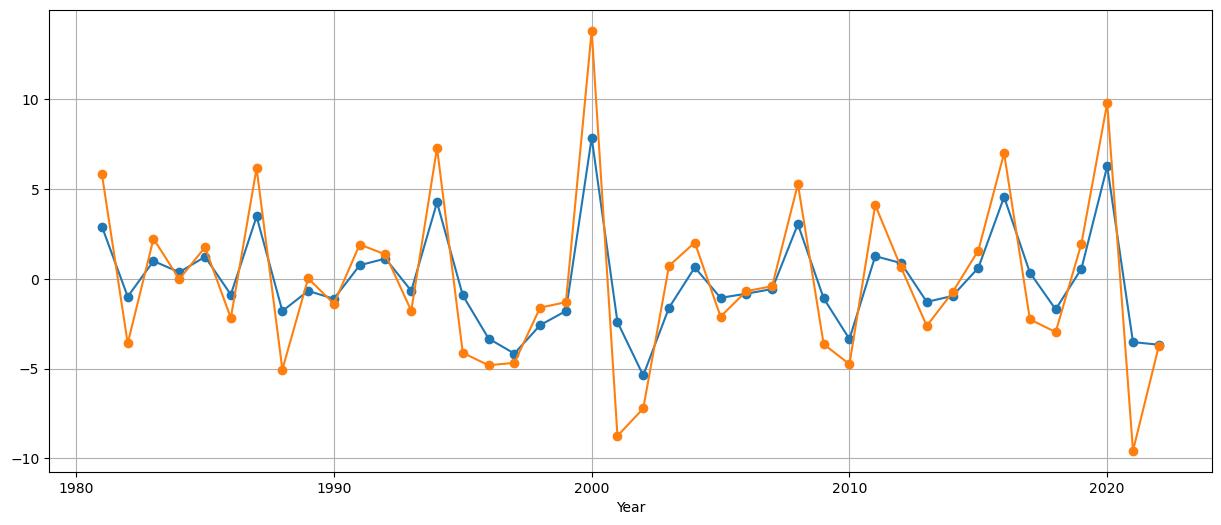

In [18]:
# Plot the filtered time series
filtered_df["Inflation, consumer prices (annual %)"].plot(figsize=(15, 6), marker="o")
detrend_df["Inflation, consumer prices (annual %)"].plot(figsize=(15, 6), marker="o")

plt.grid()
plt.show()

## Correlation test

In [19]:
original_vif_df = pd.DataFrame()

# Calculate the VIF for each predictor variable
original_vif_df["Variable"] = detrend_df.columns
original_vif_df["VIF"] = [
    variance_inflation_factor(detrend_df.values, i) for i in range(detrend_df.shape[1])
]

original_vif_df

,Variable,VIF
0,Real per Capita GDP Growth Rate (annual %),1.465929e+03
1,Real GDP growth (annual %),1.439988e+03
2,"Gross domestic product, (constant prices US$)",4.405318e+00
3,"Gross domestic product, current prices (curren...",8.824519e+01
4,Final consumption expenditure (current US$),7.978033e+12
5,General government final consumption expenditu...,3.175351e+11
6,Household final consumption expenditure (curre...,5.435847e+12
7,Gross capital formation (current US$),1.934813e+02
8,"Gross capital formation, Private sector (curr...",7.788946e+01
9,"Gross capital formation, Public sector (curre...",7.077210e+01


In [20]:
filtered_vif_df = pd.DataFrame()

# Calculate the VIF for each predictor variable
filtered_vif_df["Variable"] = filtered_df.columns
filtered_vif_df["VIF"] = [
    variance_inflation_factor(filtered_df.values, i)
    for i in range(filtered_df.shape[1])
]

filtered_vif_df

,Variable,VIF
0,Real per Capita GDP Growth Rate (annual %),1.073870e+03
1,Real GDP growth (annual %),1.074076e+03
2,"Gross domestic product, (constant prices US$)",6.447855e+00
3,"Gross domestic product, current prices (curren...",1.165721e+02
4,Final consumption expenditure (current US$),1.853333e+13
5,General government final consumption expenditu...,7.165062e+11
6,Household final consumption expenditure (curre...,1.247535e+13
7,Gross capital formation (current US$),4.146617e+02
8,"Gross capital formation, Private sector (curr...",1.321066e+02
9,"Gross capital formation, Public sector (curre...",1.059257e+02


# PCA 

Text(0, 0.5, 'cumulative explained variance')

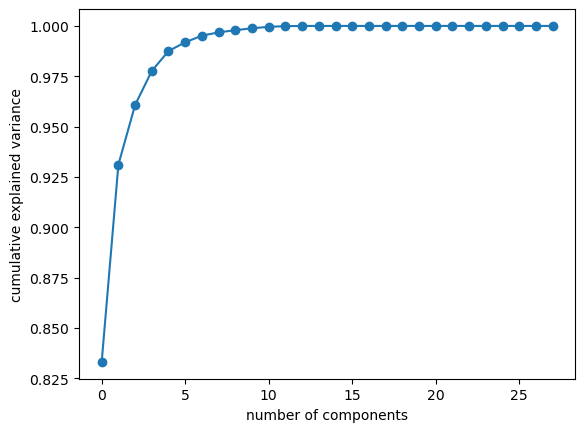

In [21]:
# Plot the scree plot to determine the number of components to use
pca = PCA().fit(filtered_df.drop(columns=["Inflation, consumer prices (annual %)"]))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker="o")
plt.xlabel("number of components")
plt.ylabel("cumulative explained variance")

In [22]:
# Apply PCA
pca = PCA(n_components=4)
pca.fit(filtered_df.drop(columns=["Inflation, consumer prices (annual %)"]))

PCA(n_components=4)

In [23]:
reduced_df = pd.DataFrame(
    pca.transform(filtered_df.drop(columns=["Inflation, consumer prices (annual %)"])),
    columns=["PC1", "PC2", "PC3", "PC4"],
    index=filtered_df.index,
)

# Add the target variable to the reduced dataframe
reduced_df["Inflation, consumer prices (annual %)"] = filtered_df[
    "Inflation, consumer prices (annual %)"
]

In [24]:
reduced_df.head()

,PC1,PC2,PC3,PC4,"Inflation, consumer prices (annual %)"
Year,,,,,
1981,-1569.226294,6.799051,472.043114,262.537392,2.906557
1982,-1755.468943,-52.018175,351.259465,118.551282,-0.995229
1983,-1777.894490,-344.594919,366.190072,-10.095059,0.987590
1984,-1742.606884,-421.291422,252.231569,-67.888495,0.364797
1985,-1657.228021,-403.284192,117.487399,-113.132908,1.222653


# Modeling 

## VAR Model

In [30]:
model = VAR(reduced_df)

results = model.fit(maxlags=10)

# Print the model summary
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 20, Dec, 2023
Time:                     21:52:02
---------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    -251.758
Nobs:                     32.0000    HQIC:                   -259.567
Log likelihood:           4242.99    FPE:               -7.41576e-119
AIC:                     -263.439    Det(Omega_mle):    -6.31706e-121
---------------------------------------------------------------------
Results for equation PC1
                                               coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------------------------
const                                             0.012327         0.000043          283.847           0.000
L1.PC1                                            0.3

/home/mmostafa/miniconda3/envs/aienv10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/mmostafa/miniconda3/envs/aienv10/lib/python3.10/site-packages/statsmodels/tsa/vector_ar/var_model.py:1559: RuntimeWarning: invalid value encountered in sqrt
  stderr = np.sqrt(np.diag(self.cov_params()))


# Diagnostic Tests

The Ljung-Box test is a generalization of the Box-Pierce test, which tests the null hypothesis of no autocorrelation in the residuals of a regression mode

In [26]:
p_value = het_arch(decomposed.resid.dropna())[1]

if p_value < SIGNIFICANT_LEVEL:
    print("Reject null hypothesis, residuals are correlated")
else:
    print("Fail to reject null hypothesis, residuals are not correlated")

Fail to reject null hypothesis, residuals are not correlated


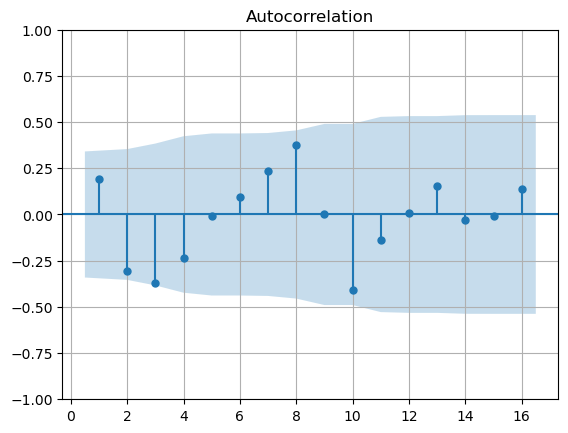

In [27]:
# ACF plot to check the best lag order
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(decomposed.resid.dropna(), zero=False)

plt.grid()
plt.show()

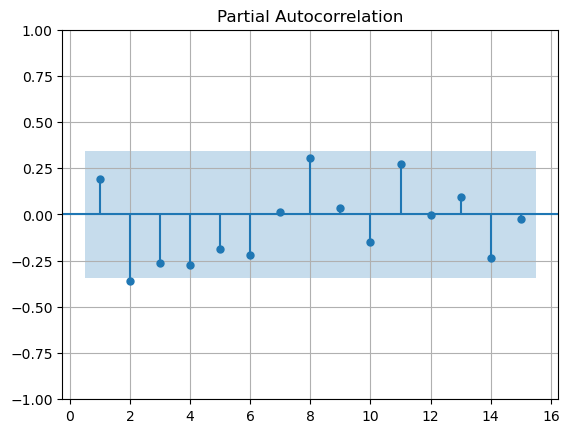

In [28]:
# BACF plot to check the best lag
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(decomposed.resid.dropna(), lags=15, zero=False)

plt.grid()

The Jarque-Bera test is a statistical test used to determine whether a given dataset follows a normal distribution.